## Dataset Analysis and Preparation

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import cv2
from tqdm import tqdm

#### LABELS
* MEL - Melanoma
* NV - Melanocytic Nevi
* BCC - Basal Cell Carcinoma
* AKIEC - Actinic Keratoses (Solar Keratoses)
* BKL - Benign Keratosis
* DF - Dermatofibroma
* VASC - Vascular Skin Lesions

### Creating Dataset folder structure from CSV

In [118]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

In [119]:
print(os.listdir(base))

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [2]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("ISIC2018GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

df_labels.set_index('image', inplace=True)
df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [121]:
nv_idx = df_labels[df_labels['label']=="NV"].index
drop_indices = np.random.choice(nv_idx, 4500, replace=False)
df_labels = df_labels.drop(drop_indices)

In [122]:
images = os.listdir('HAM_images')

for image in tqdm(images):
    
    try:
        fname=image[:-4]
        label=df_labels.loc[fname, "label"]
        src = os.path.join('HAM_images', image)
        dst = os.path.join('HAM_Dataset', label, image)
        shutil.copyfile(src, dst)
    except:
        continue

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [05:51<00:00, 28.51it/s]


### Frequency count of samples

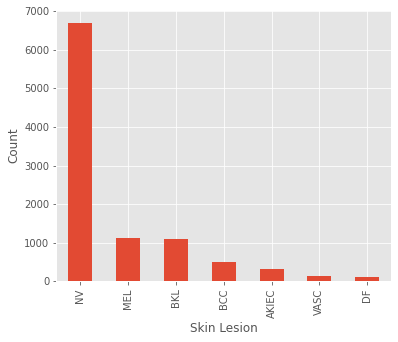

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 5))
df_labels['label'].value_counts().plot(kind='bar', ax=ax1)
plt.ylabel('Count')
plt.xlabel('Skin Lesion')
plt.show()

In [ ]:
# class weights

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

### Data Preparation & Batching

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=180, 
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               rescale=1./255,
                               validation_split=0.15)

In [126]:
data_dir = 'HAM_Dataset'
batch_size = 10
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 12843 images belonging to 7 classes.
Found 2261 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = image_path
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

### Data Augmentation

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=180, 
                               width_shift_range=0.15,
                               height_shift_range=0.15,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest',
                               rescale=1./255,
                               validation_split=0.15)


batch_size=16
train_image_gen = image_gen.flow_from_directory('images', 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

imgs=[]                                                
for i in range(16):
    x=next(train_image_gen)
    imgs.append(x[0][0])

Found 1 images belonging to 1 classes.


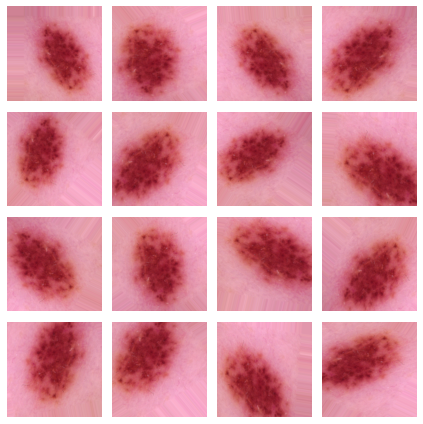

In [92]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

# next_pix = image_path
# random.shuffle(next_pix)

for i, img in enumerate(imgs):
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    plt.imshow(img)

plt.tight_layout()
plt.show()